In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.nn import functional as F

import json
import re

import numpy as np

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !pip3 install pymorphy2[fast]
# !pip3 install gensim
# !pip3 install torchtext

In [3]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

def normal_form(word):
    return morph.parse(word)[0].normal_form

In [4]:
# import pandas as pd

# df = pd.read_csv('../data/lenta-ru-news.csv')
# with open('../data/lenta-texts.json', 'w') as f:
#     json.dump([{'text':i} for i in df.title], f)

In [79]:
# # with open('../data/lenta-texts.json', 'r') as f:
# #     q = json.load(f)
# # with open('../data/lenta-texts-small.json', 'w') as f:
# #     json.dump(q[-10000:], f)

# # with open('../data/lenta-texts-small.json', 'r') as f:
# #     q = json.load(f)
# # with open('../data/lenta-texts-small-val.json', 'w') as f:
# #     json.dump(q[-100:], f)

# with open('../data/mem_big.json', 'r') as f:
#     q = json.load(f)
# print(len(q))
# import random
# random.shuffle(q)
# with open('../data/mem-val.json', 'w') as f:
#     json.dump(q[-100:], f)
    
# with open('../data/mem-train.json', 'w') as f:
#     json.dump(q[:-100], f)


9800


In [6]:
# texts = []

# for file in tqdm_notebook(['lenta-texts-small.json', 'navalny.json', 'ntv.json', 'portnyagin.json', 'tvrain.json']):
#     with open('../data/' + file, 'r') as f:
#         temp_file = json.load(f)
#         for text in temp_file:
#             texts.append({'text' : text['text']})
# print(len(texts))

# with open('../data/joined.json', 'w') as f:
#     json.dump(texts, f)


21466


In [7]:
def preprocess(text):
    return ' '.join([normal_form(i) for i in re.findall(r'[А-я]+', text) if len(i) > 2])

In [8]:
import torchtext.vocab as vocab

vectors = vocab.Vectors('../data/ruwiki_20180420_100d.txt') # file created by gensim


In [9]:
PAD_IDX = len(vectors.stoi) - 2
UNK_IDX = len(vectors.stoi) - 1
TOTAL_EMBS = len(vectors)

In [10]:
def vectorize(text):
    try:
        text = preprocess(text['text'])
    except TypeError as e:
        return None
    inds = []
    if len(text.split()) < 3:
        return None
    for word in text.split():
        try:
            inds.append(vectors.stoi[word])
        except KeyError:
            inds.append(UNK_IDX)
    if len(inds) < 2:
        return None
    while len(inds) < 90:
        inds.append(PAD_IDX)
    return inds[:90]

In [11]:
def vectorize_all(texts):
    ans = []
    for text in tqdm_notebook(texts):
        try:
            vec = vectorize(text)
        except Exception as e:
            continue
        if vec:
            ans.append(vec)
    return ans

In [12]:
class FasttextSet(Dataset):
    def __init__(self, cosmo, nocosmo):
        '''
        data - json file name
        '''
        with open(nocosmo, 'r') as f:
            self.nocosmo = json.load(f)
        self.nocosmo = np.array(vectorize_all(self.nocosmo))

        with open(cosmo, 'r') as f:
            self.cosmo = json.load(f)
        self.cosmo = np.array(vectorize_all(self.cosmo))
        
        
        self.x = np.row_stack([self.cosmo, self.nocosmo])
        self.y = np.concatenate([np.ones(len(self.cosmo)), np.zeros(len(self.nocosmo))])
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, ind):
        return torch.Tensor(self.x[ind]).long(), self.y[ind]

In [13]:
memLoader = DataLoader(FasttextSet('../data/mem_big.json', '../data/joined.json'),
                       batch_size=32, shuffle=True)

In [14]:
memLoader_val = DataLoader(FasttextSet('../data/mem-val.json', '../data/lenta-texts-small-val.json'),
                           batch_size=32, shuffle=True)

In [71]:
loss = nn.BCEWithLogitsLoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(input, target)


In [74]:
input

tensor([-0.0130, -0.6876,  1.0753], requires_grad=True)

In [75]:
target

tensor([1., 0., 0.])

In [15]:
class SimilarityNet(nn.Module):
    def __init__(self, ):
        super(SimilarityNet, self).__init__()
        self.embs = nn.Embedding(len(vectors), embedding_dim=100, padding_idx=PAD_IDX).from_pretrained(
            torch.FloatTensor(vectors.vectors)
        )
        self.process = nn.Sequential(
            nn.Conv1d(100, 128, 15),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.05),
            nn.Conv1d(128, 64, 9),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.05),
            nn.Conv1d(64, 32, 5),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.05),
            nn.Conv1d(32, 32, 5),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.05),
        )
        self.fc = nn.Sequential(
            nn.Linear(32, 1),
#             nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.process(self.embs(x).permute(0, 2, 1))
        x = torch.mean(x, dim=-1)
        return self.fc(x)

In [38]:
simnet = SimilarityNet().cuda()
criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(simnet.parameters())

In [39]:
train_losses = []

for epoch in tqdm_notebook(range(100)):
    for x, target in tqdm_notebook(memLoader, leave=False):
        x, target = x.cuda(), target.cuda()
        optim.zero_grad()
        pred = simnet(x)
        loss = criterion(pred, target.unsqueeze(1).float())
        train_losses.append(loss.item())
        loss.backward()
        optim.step()


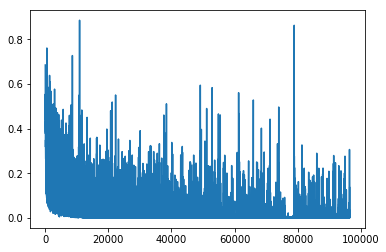

In [40]:
plt.plot(train_losses)

In [42]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


y_true = []
y_pred = []

for x, target in tqdm_notebook(memLoader_val):
    pred = simnet(x.cuda())
    for i, j in zip(pred.cpu().squeeze().detach().numpy(), target.detach().numpy()):
        y_pred.append(sigmoid(i))
        y_true.append(j)
        

In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.9974410774410775

In [44]:
with open('../data/mem-val.json', 'r') as f:
    c = json.load(f)
with open('../data/lenta-texts-small-val.json', 'r') as f:
    l = json.load(f)
    

In [48]:
def test_strs(x):
    x = vectorize(x)
    if not x:
        return None
    x = torch.Tensor(x).long().unsqueeze(0)
    ans = sigmoid(simnet(x.cuda()).item())
    return ans

In [49]:
c[80]

{'text': 'За кулисами съемки февральского Cosmo'}

In [50]:
for text in c:
    ans = test_strs(text)
    if ans:
        print(text, '{0:.3f} '.format(ans))


{'text': 'Любите ли вы цветы так, как мы?)'} 0.134 
{'text': 'Beauty-редактор нашего сайта теперь - лицо краски для волос:) Круто?'} 0.006 
{'text': 'а вот и сигнал!!!!!!! лайк?'} 0.003 
{'text': 'часть нашего фэшн-отдела уже завтра уедет в лееето!! для ярких фотоисторий. остальная редакция пока живет в зиме;))'} 0.129 
{'text': 'а наши чудесные партнеры (по работе!!) продолжают нас радовать сюрпризами!! вот она, главная вещь для каждой cosmo-девушки;) спасибо, #trendsbrands!!'} 0.327 
{'text': 'сегодня прислали очень красивый и очень cosmo (!!!) подарок;) спасибо! и всем прекрасных нескучных выходных!'} 0.072 
{'text': 'Во-первых, С ПЕРВЫМ днем весны!!! Во-вторых, С ДНЕМ рождения, Алиса!!!!'} 0.165 
{'text': 'Всем от привет Алины Красновой с иерусалимского марафона!'} 0.802 
{'text': 'слева - кадр с юбкой до колен, не вошедший в мартовский номер, а справа - страничка из журнала. за какой вы лук?!) Еще больше о юбоках любой длины и том, как из носить, - в марте, понятное дело;)#cosmopo

In [51]:
for text in l:
    ans = test_strs(text)
    if ans:
        print(text, '{0:.3f} '.format(ans))


{'text': 'Явлинский связывает кремлевский скандал с\xa0коллективным прозрением Запада'} 0.000 
{'text': 'В Норильске четыре рабочих погибли в\xa0результате взрыва'} 0.001 
{'text': 'Еще одно назначение Путина'} 0.000 
{'text': 'В "Bank of\xa0New York" подчищали и\xa0уничтожали документы'} 0.000 
{'text': 'Трое террористов погибли во\xa0время терактов в\xa0Хайфе и\xa0Тверии'} 0.004 
{'text': 'В драке на\xa0Манежной площади пострадали шесть человек'} 0.000 
{'text': 'Сторонники Станислава Дерева не\xa0подчинились Дереву'} 0.002 
{'text': 'В Каму вытекло 100\xa0тонн мазута'} 0.002 
{'text': 'Правительство Чечни считает, что Россия начала войну'} 0.000 
{'text': 'Эпидемия краснухи в\xa0Белгородской области'} 0.001 
{'text': 'Еще 11\xa0заложников вернулись из\xa0чеченского плена'} 0.000 
{'text': 'В Непале в\xa0авиакатастрофе погибли 15\xa0человек'} 0.002 
{'text': '"Держава" выходит из "Отечества"'} 0.000 
{'text': 'Пентагон отключается от\xa0Интернета, опасаясь российских хакеров'} 0.000 

In [53]:
test_strs({'text':
           'Вот такие дифирамбы поют Сашка поклонники 🤔А вы что скажете? Черно по делу выступает на Лобном или не всегда?'})

0.7283859990743662

In [70]:
simnet.cpu()
torch.save(simnet, '../models/simnet.torch')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type SimilarityNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [63]:
import similarity as sim

In [69]:
sim.process_str({'text':
                 ' поклонники 🤔всегда?'})